In [ ]:
import pandas as pd
import numpy as np
import re
import os
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch.nn as nn
import matplotlib.pyplot as plt
#import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import time
import transformers
from transformers import AutoModel, BertTokenizerFast
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import BertTokenizer, BertModel
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
# specify GPU
device = torch.device("cuda")
from wordcloud import WordCloud
import itertools
import seaborn as sns
import io

In [ ]:
!pip install wandb -qU

In [ ]:
import wandb

wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [ ]:
import wandb

# Initialize W&B run
wandb.init(project="Indic_Bert_Fake_News_Prediction", config={
    "learning_rate": 1e-5,
    "epochs": 5,
    "batch_size": 32,
    "model": "google/muril-base-cased"
})


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
true_news = pd.read_csv('/content/drive/MyDrive/dataset/authentic.csv')

print(true_news)

      Unnamed: 0                                                URL  \
0              0  https://hindi.oneindia.com/news/india/when-aam...   
1              1  https://hindi.oneindia.com/news/india/ec-suspe...   
2              2  https://hindi.oneindia.com/news/india/assam-yo...   
3              3  https://hindi.oneindia.com/news/india/tamil-na...   
4              4  https://hindi.oneindia.com/news/india/aamir-kh...   
...          ...                                                ...   
6152        6152  https://www.bhaskar.com/international/news/6-p...   
6153        6153  https://www.bhaskar.com/career/news/fci-sarkar...   
6154        6154  https://www.bhaskar.com/local/uttar-pradesh/al...   
6155        6155  https://www.bhaskar.com/career/news/dmw-sarkar...   
6156        6156  https://www.bhaskar.com/business/news/loan-hom...   

                                                  Title  \
0     जब जूही चावला से आमिर खान ने 7 सालों तक नहीं क...   
1     नंदीग्राम हमले पर चुनाव

In [ ]:
fake_news =pd.read_csv('/content/drive/MyDrive/dataset/fake.csv')
print(fake_news)

      Unnamed: 0                                                URL  \
0              0  https://hindi.boomlive.in/fact-check/go-back-m...   
1              1  https://hindi.boomlive.in/fact-check/-kisan-an...   
2              2  https://hindi.boomlive.in/fact-check/delhi-hig...   
3              3  https://hindi.boomlive.in/fact-check/uttar-pra...   
4              4  https://hindi.boomlive.in/fact-check/undertake...   
...          ...                                                ...   
6482        2994  https://www.vishvasnews.com/politics/fact-chec...   
6483        2995  https://www.vishvasnews.com/viral/fact-check-n...   
6484        2996  https://www.vishvasnews.com/viral/fact-check-v...   
6485        2997  https://www.vishvasnews.com/health/fact-check-...   
6486        2998  https://www.vishvasnews.com/politics/fact-chec...   

                                                  Title  \
0     रोड पर 'गो बैक मोदी' का नारा दिखाती यह फ़ोटो तम...   
1     किसान आंदोलन: कीलों के 

In [ ]:
true_news = true_news.drop("dates", axis='columns')

In [ ]:
fake_news = fake_news.drop("dates", axis='columns')

In [ ]:
# Try dropping columns that start with 'Unnamed'
true_news = true_news.loc[:, ~true_news.columns.str.startswith('Unnamed')]
print( true_news.tail())

                                                    URL  \
6152  https://www.bhaskar.com/international/news/6-p...   
6153  https://www.bhaskar.com/career/news/fci-sarkar...   
6154  https://www.bhaskar.com/local/uttar-pradesh/al...   
6155  https://www.bhaskar.com/career/news/dmw-sarkar...   
6156  https://www.bhaskar.com/business/news/loan-hom...   

                                                  Title Authors  \
6152  चीन में 10 साल का सबसे खतरनाक रेतीला तूफान: रा...      []   
6153  सरकारी नौकरी: फूड कॉर्पोरेशन ऑफ इंडिया ने असिस...      []   
6154  UP में पंचायत चुनाव पर हाईकोर्ट का आदेश: अखिले...      []   
6155  सरकारी नौकरी: रेलवे ने 8वीं-10वीं पास कैंडिडेट...      []   
6156  सस्ता लोन: बैंक ऑफ बड़ौदा से लोन लेना हुआ सस्त...      []   

                                                Summary  \
6152  Hindi NewsInternational6 People Killed So Far ...   
6153  Hindi NewsCareerFCI Sarkari Naukri | FCI Recru...   
6154  Hindi NewsLocalUttar pradeshAllahabadUP Gram P...   
6155  

In [ ]:
# Try dropping columns that start with 'Unnamed'
fake_news = fake_news.loc[:, ~fake_news.columns.str.startswith('Unnamed')]
print(fake_news.tail())

                                                    URL  \
6482  https://www.vishvasnews.com/politics/fact-chec...   
6483  https://www.vishvasnews.com/viral/fact-check-n...   
6484  https://www.vishvasnews.com/viral/fact-check-v...   
6485  https://www.vishvasnews.com/health/fact-check-...   
6486  https://www.vishvasnews.com/politics/fact-chec...   

                                                  Title Authors  \
6482  Fact Check: इंडियन ऑयल और अडानी गैस का ज्वाइंट...      []   
6483  Fact Check: No, Sachin Tendulkar has not repli...      []   
6484  Fact Check: पेट्रोल की कीमत का वायरल ब्रेकअप ग...      []   
6485  Fact Check: कोरोना वायरस से नहीं बचाती है अगरब...      []   
6486  Fact Check : शाही स्‍नान को लेकर प्रियंका गांध...      []   

                                                Summary  \
6482  Shareनई दिल्‍ली (Vishvas News)। सोशल मीडिया पर...   
6483  Shareनई दिल्‍ली (Vishvas News)। सोशल मीडिया पर...   
6484  Shareविश्वास न्यूज (नई दिल्ली)। सोशल मीडिया पर...   
6485  

In [ ]:
# Check for missing values
print( true_news.isnull().sum())

URL         0
Title       0
Authors     0
Summary     0
Keywords    0
dtype: int64


In [ ]:
# Check for missing values
print( fake_news.isnull().sum())

URL         0
Title       0
Authors     0
Summary     0
Keywords    0
dtype: int64


In [ ]:
# Iterate through each column in the DataFrame
for i in list(true_news):
  true_news[i]=true_news[i].str.replace('|', '')
  true_news[i]=true_news[i].str.replace('?', '')
  true_news[i]=true_news[i].str.replace(':', '')
  true_news[i]=true_news[i].str.replace(';', '')
  true_news[i]=true_news[i].str.replace("'", '')
  true_news[i]=true_news[i].str.replace('"', '')
  true_news[i]=true_news[i].str.replace(',', '')
  true_news[i]=true_news[i].str.replace('.', '')
  true_news[i]=true_news[i].str.replace('(', '')
  true_news[i]=true_news[i].str.replace(')', '')
  true_news[i]=true_news[i].str.replace('\n', '')
  true_news[i]=true_news[i].str.replace('&', '')

In [ ]:
for i in list(fake_news):
  fake_news[i]=fake_news[i].str.replace('|', '')
  fake_news[i]=fake_news[i].str.replace('?', '')
  fake_news[i]=fake_news[i].str.replace(':', '')
  fake_news[i]=fake_news[i].str.replace(';', '')
  fake_news[i]=fake_news[i].str.replace("'", '')
  fake_news[i]=fake_news[i].str.replace('"', '')
  fake_news[i]=fake_news[i].str.replace(',', '')
  fake_news[i]=fake_news[i].str.replace('.', '')
  fake_news[i]=fake_news[i].str.replace('(', '')
  fake_news[i]=fake_news[i].str.replace(')', '')
  fake_news[i]=fake_news[i].str.replace('\n', '')
  fake_news[i]=fake_news[i].str.replace('&', '')
  fake_news[i]=fake_news[i].str.replace('।', '')


In [ ]:
# Iterate through each column in the DataFrame
for i in list(fake_news):
    # Check if the column is of string type
    if fake_news[i].dtype == 'object':
        # Apply the string replacement operations in a chained manner
        fake_news[i] =fake_news[i].str.replace('|', '').replace('?', '').replace(':', '').replace(';', '').replace("'", '').replace('"', '').replace(',', '').replace('.', '').replace('(', '').replace(')', '').replace('\n', '').replace('&', '')


In [ ]:
# Iterate through each column in the DataFrame
for i in list(true_news):
    # Check if the column is of string type
    if true_news[i].dtype == 'object':
        # Apply the string replacement operations in a chained manner
        true_news[i] =true_news[i].str.replace('|', '').replace('?', '').replace(':', '').replace(';', '').replace("'", '').replace('"', '').replace(',', '').replace('.', '').replace('(', '').replace(')', '').replace('\n', '').replace('&', '')


In [ ]:
true_news.tail()

,URL,Title,Authors,Summary,Keywords
6152,https//wwwbhaskarcom/international/news/6-peop...,चीन में 10 साल का सबसे खतरनाक रेतीला तूफान राज...,[],Hindi NewsInternational6 People Killed So Far ...,[ह समत म तक रत स तफन पर सल रजधन न लग बजग रतल स...
6153,https//wwwbhaskarcom/career/news/fci-sarkari-n...,सरकारी नौकरी फूड कॉर्पोरेशन ऑफ इंडिया ने असिस्...,[],Hindi NewsCareerFCI Sarkari Naukri FCI Recrui...,[और अससटट जनरल ह भ फड सकत कर सरकर मडकल मनजर पर...
6154,https//wwwbhaskarcom/local/uttar-pradesh/allah...,UP में पंचायत चुनाव पर हाईकोर्ट का आदेश अखिलेश...,[],Hindi NewsLocalUttar pradeshAllahabadUP Gram P...,[थ हई ह म हईकरट सरकर आरकषण समय पर न करन लग चनव...
6155,https//wwwbhaskarcom/career/news/dmw-sarkari-n...,सरकारी नौकरी रेलवे ने 8वीं-10वीं पास कैंडिडेट्...,[],Hindi NewsCareerDMW Sarkari Naukri DMW Appren...,[नकल ह कडडटस रलव पस हन वकस कर सरकर मरच लए आवदन...
6156,https//wwwbhaskarcom/business/news/loan-home-l...,सस्ता लोन बैंक ऑफ बड़ौदा से लोन लेना हुआ सस्ता...,[],Hindi NewsBusinessLoan Home Loan Bank Of Bar...,[रट मलग बडद बक ह म स क पर हम ससत ऑफ कटत लन 675...


In [ ]:
fake_news.tail()

,URL,Title,Authors,Summary,Keywords
6482,https//wwwvishvasnewscom/politics/fact-check-i...,Fact Check इंडियन ऑयल और अडानी गैस का ज्वाइंट ...,[],Shareनई दिल्‍ली Vishvas News सोशल मीडिया पर दो...,[पर रह लकर क ह वचर इडयन भरमक पसट और जवइट यह कय...
6483,https//wwwvishvasnewscom/viral/fact-check-no-s...,Fact Check No Sachin Tendulkar has not replied...,[],Shareनई दिल्‍ली Vishvas News सोशल मीडिया पर एक...,[टवट पर tendulkar twitter rana क ह check fact ...
6484,https//wwwvishvasnewscom/viral/fact-check-vira...,Fact Check पेट्रोल की कीमत का वायरल ब्रेकअप गल...,[],Shareविश्वास न्यूज नई दिल्ली सोशल मीडिया पर पे...,[ह वयरल वल पर बदल टकस इस स पटरल म बरकअप रजय हस...
6485,https//wwwvishvasnewscom/health/fact-check-no-...,Fact Check कोरोना वायरस से नहीं बचाती है अगरबत...,[],Shareनई दिल्ली विश्वास न्यूज एक यूट्यूब चैनल प...,[वयरस ह झठ सकत नह बचत वडय स दव म अगरबतत करन और क]
6486,https//wwwvishvasnewscom/politics/fact-check-p...,Fact Check शाही स्‍नान को लेकर प्रियंका गांधी...,[],Shareनई दिल्‍ली Vishvas News सोशल मीडिया पर का...,[हम शह ह टवट नह पर गध फरज परयक म स यह सनन न लक...


In [ ]:
# def clean_text(text):
#     # Remove non-alphanumeric characters
#     text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
#     # Remove extra spaces
#     text = re.sub(r'\s+', ' ', text).strip()
#     return text


In [ ]:
# pip install pandas nltk scikit-learn


In [ ]:
import nltk
# nltk.download('punkt')
# nltk.download('stopwords')


**Stemming**

In [ ]:
suffixes = {
    1: ["ो", "े", "ू", "ु", "ी", "ि", "ा"],
    2: ["कर", "ाओ", "िए", "ाई", "ाए", "ने", "नी", "ना", "ते", "ीं", "ती", "ता", "ाँ", "ां", "ों", "ें"],
    3: ["ाकर", "ाइए", "ाईं", "ाया", "ेगी", "ेगा", "ोगी", "ोगे", "ाने", "ाना", "ाते", "ाती", "ाता", "तीं", "ाओं", "ाएं", "ुओं", "ुएं", "ुआं"],
    4: ["ाएगी", "ाएगा", "ाओगी", "ाओगे", "एंगी", "ेंगी", "एंगे", "ेंगे", "ूंगी", "ूंगा", "ातीं", "नाओं", "नाएं", "ताओं", "ताएं", "ियाँ", "ियों", "ियां"],
    5: ["ाएंगी", "ाएंगे", "ाऊंगी", "ाऊंगा", "ाइयाँ", "ाइयों", "ाइयां"],
}

def hi_stem(word):
    for L in 5, 4, 3, 2, 1:
        if len(word) > L + 1:
            for suf in suffixes[L]:
                if word.endswith(suf):
                    return word[:-L]
    return word

In [ ]:
id=list(fake_news.index)
id1=list(true_news.index)


In [ ]:
str_temp=""
count=0
for i in list(fake_news):
  count=0
  for j in list(fake_news[i]):
    for words in j.split():
      str_temp+=hi_stem(words)
      str_temp+=" "
    fake_news.loc[id[count],i]=str_temp
    str_temp=""
    count+=1

In [ ]:

str_temp=""
count=0
for i in list(true_news):
  count=0
  for j in list(true_news[i]):
    for words in j.split():
      str_temp+=hi_stem(words)
      str_temp+=" "
    true_news.loc[id1[count],i]=str_temp
    str_temp=""
    count+=1

In [ ]:
true_news.tail()

,URL,Title,Authors,Summary,Keywords
6152,https//wwwbhaskarcom/international/news/6-peop...,चीन में 10 साल का सबस खतरनाक रेतील तूफान राजधा...,[],Hindi NewsInternational6 People Killed So Far ...,[ह समत म तक रत स तफन पर सल रजधन न लग बजग रतल स...
6153,https//wwwbhaskarcom/career/news/fci-sarkari-n...,सरकार नौकर फूड कॉर्पोरेशन ऑफ इंडिय ने असिस्टें...,[],Hindi NewsCareerFCI Sarkari Naukri FCI Recruit...,[और अससटट जनरल ह भ फड सकत कर सर मडकल मनजर पर आ...
6154,https//wwwbhaskarcom/local/uttar-pradesh/allah...,UP में पंचायत चुनाव पर हाईकोर्ट का आदेश अखिलेश...,[],Hindi NewsLocalUttar pradeshAllahabadUP Gram P...,[थ हई ह म हईकरट सर आरकषण समय पर न करन लग चनव क...
6155,https//wwwbhaskarcom/career/news/dmw-sarkari-n...,सरकार नौकर रेलव ने 8वीं-10व पास कैंडिडेट्स के ...,[],Hindi NewsCareerDMW Sarkari Naukri DMW Apprent...,[नकल ह कडडटस रलव पस हन वकस कर सर मरच लए आवदन न...
6156,https//wwwbhaskarcom/business/news/loan-home-l...,सस् लोन बैंक ऑफ बड़ौद से लोन ले हुआ सस् अब 675...,[],Hindi NewsBusinessLoan Home Loan Bank Of Barod...,[रट मलग बडद बक ह म स क पर हम ससत ऑफ कटत लन 675...


In [ ]:
fake_news.tail()

,URL,Title,Authors,Summary,Keywords
6482,https//wwwvishvasnewscom/politics/fact-check-i...,Fact Check इंडियन ऑयल और अडा गैस का ज्वाइंट वे...,[],Shareनई दिल्‍ल Vishvas News सोशल मीडिय पर दो त...,[पर रह लकर क ह वचर इडयन भरमक पसट और जवइट यह कय...
6483,https//wwwvishvasnewscom/viral/fact-check-no-s...,Fact Check No Sachin Tendulkar has not replied...,[],Shareनई दिल्‍ल Vishvas News सोशल मीडिय पर एक ट...,[टवट पर tendulkar twitter rana क ह check fact ...
6484,https//wwwvishvasnewscom/viral/fact-check-vira...,Fact Check पेट्रोल की कीमत का वायरल ब्रेकअप गल...,[],Shareविश्वास न्यूज नई दिल्ल सोशल मीडिय पर पेट्...,[ह वयरल वल पर बदल टकस इस स पटरल म बरकअप रजय हस...
6485,https//wwwvishvasnewscom/health/fact-check-no-...,Fact Check कोरो वायरस से नह बच है अगरबत् वीडिय...,[],Shareनई दिल्ल विश्वास न्यूज एक यूट्यूब चैनल पर...,[वयरस ह झठ सकत नह बचत वडय स दव म अगरबतत करन और...
6486,https//wwwvishvasnewscom/politics/fact-check-p...,Fact Check शाह स्‍नान को ले प्रियंक गांध ने नह...,[],Shareनई दिल्‍ल Vishvas News सोशल मीडिय पर कांग...,[हम शह ह टवट नह पर गध फरज परयक म स यह सनन न लक...


**Stop words removal**

In [ ]:
stop=open('/content/drive/MyDrive/dataset/final_stopwords.txt')
stopwords=[]
for x in stop:
  x = x.replace('\n', '')
  stopwords.append(x)

In [ ]:
stopwords

['मैं',
 'मुझको',
 'मेरा',
 'अपने आप को',
 'हमने',
 'हमारा',
 'अपना',
 'हम',
 'आप',
 'आपका',
 'तुम्हारा',
 'अपने आप',
 'स्वयं',
 'वह',
 'इसे',
 'उसके',
 'खुद को',
 'कि वह',
 'उसकी',
 'उसका',
 'खुद ही',
 'यह',
 'इसके',
 'उन्होने',
 'अपने',
 'क्या',
 'जो',
 'किसे',
 'किसको',
 'कि',
 'ये',
 'हूँ',
 'होता है',
 'रहे',
 'थी',
 'थे',
 'होना',
 'गया',
 'किया जा रहा है',
 'किया है',
 'है',
 'पडा',
 'होने',
 'करना',
 'करता है',
 'किया',
 'रही',
 'एक',
 'लेकिन',
 'अगर',
 'या',
 'क्यूंकि',
 'जैसा',
 'जब तक',
 'जबकि',
 'की',
 'पर',
 'द्वारा',
 'के लिए',
 'साथ',
 'के बारे में',
 'खिलाफ',
 'बीच',
 'में',
 'के माध्यम से',
 'दौरान',
 'से पहले',
 'के बाद',
 'ऊपर',
 'नीचे',
 'को',
 'से',
 'तक',
 'से नीचे',
 'करने में',
 'निकल',
 'बंद',
 'से अधिक',
 'तहत',
 'दुबारा',
 'आगे',
 'फिर',
 'एक बार',
 'यहाँ',
 'वहाँ',
 'कब',
 'कहाँ',
 'क्यों',
 'कैसे',
 'सारे',
 'किसी',
 'दोनो',
 'प्रत्येक',
 'ज्यादा',
 'अधिकांश',
 'अन्य',
 'में कुछ',
 'ऐसा',
 'में कोई',
 'मात्र',
 'खुद',
 'समान',
 'इसलिए',
 'बहुत',
 'सकता',
 '

In [ ]:
str_temp=""
count=0
for i in fake_news.columns:
  count=0
  for j in fake_news[i]:
    for words in j.split():
      if words not in stopwords:
        str_temp+=words
        str_temp+=" "
    fake_news.loc[count,i]=str_temp.strip()
    str_temp=""
    count+= 1

fake_news.head()

,URL,Title,Authors,Summary,Keywords
0,https//hindiboomlivein/fact-check/go-back-modi...,रोड गो बैक मोद नार दिख फ़ोट तमिलनाड नह,[Saket Tiwari],इसक पहल तस्वीर वायरल रोड गो बैक मोद लिख दिख है...,[मद नह नर म भ तसवर ह रड रह फ़ट वयरल बक क]
1,https//hindiboomlivein/fact-check/-kisan-andol...,किसान आंदोलन कील के जवाब बि टायर के ट्रैक्टर व...,[Anmol Alphonso],धात के पह वाल ट्रैक्टर्स पुरा असंबंधित तस्वीर ...,[टरकटर म ह कसन टयर बन वयरल तसवर जवब क]
2,https//hindiboomlivein/fact-check/delhi-high-c...,क्य दिल्ल हाईकोर्ट गिरफ़्तार सभ किसान छोड़ आदेश दिय,[Mohammad Salman],सोशल मीडिय वायरल पोस्ट दाव किय रह 26 जनवर आयोज...,[दलल म छड़न ह हईकरट कसन पसट न कय गरफ़तर दय वयरल ...
3,https//hindiboomlivein/fact-check/uttar-prades...,उत्तर प्रदेश सुसाइड विक्टिम फ़ोट कोलक के मर्डर ...,[Anshita Bhatt Nivedita Niranjankumar],उत्तर प्रदेश Uttar Pradesh आत्महत्य suicide वा...,[उसक वकटम रप म थ मरडर ह ससइड फ़ट कय परदश वयरल स...
4,https//hindiboomlivein/fact-check/undertaker-w...,अंडरटे नह किय किसान आंदोलन समर्थन वायरल ट्वीट ...,[Saket Tiwari],दिल्ल सीम केंद्र द्वार लाग तीन कृष कानून विरोध...,[म नह फ़रज़ अडरट ह टवट कसन रह न कय वयरल समरथन क]


In [ ]:
str_temp=""
count=0
for i in true_news.columns:
  count=0
  for j in true_news[i]:
    for words in j.split():
      if words not in stopwords:
        str_temp+=words
        str_temp+=" "
    true_news.loc[count,i]=str_temp.strip()
    str_temp=""
    count+= 1

true_news.head()

,URL,Title,Authors,Summary,Keywords
0,https//hindioneindiacom/news/india/when-aamir-...,जूह चावल आमिर खान 7 साल नह बात फिल्म इश्क शूटि...,[Oi-Akarsh Shukla],सात साल दूसर नह बातआपक जान हैरा होग सुपरहिट फि...,[न स बत म कय शटग हआ नह फलम क सल थ जह आमर]
1,https//hindioneindiacom/news/india/ec-suspends...,नंदीग्राम हमल चुनाव आयोग बड़ कार्रव हट मम बनर्...,[Oi-Ankur Kumar],मम बनर्ज फोट शेयर बोल प्रकाश राज \मैं जयकांत श...,[न आयग हमल चनव म नदशक स सरकष नदगरम बनरज हटए मम...
2,https//hindioneindiacom/news/india/assam-yogen...,असम योगेंद्र यादव जेल राइजर दल के अध्यक्ष मुला...,[Oi-Ashutosh Tiwari],असम कांग्रेस साध राजनाथ सिंह निश कहा- धर्म विश...,[हमर गगई न स चनव म कह बजप यगदर लकषय रइजर यदव क...
3,https//hindioneindiacom/news/india/tamil-nadu-...,तमिलनाड सुबह BJP एंट्र ले वाल DMK विधायक मिल ट...,[Oi-Vivek Singh],सरवणन टिकट मिल नाराजगीरविवार सुबह तिरुप्पारनकु...,[स सबह तमलनड नह वधयक करयकरतओ नरजग शमल थ लन न व...
4,https//hindioneindiacom/news/india/aamir-khan-...,Happy Bday Aamir Khan इमरान हाशम बदनाम असल Kis...,[Oi-Ankur Sharma],दिलधक-धक गर्ल माधुर दीक्षित के आमिर सिर्फ एक-द...,[आमर असल सन न म थ खन फलम क इमरन हशम kisser kha...


In [ ]:
true_news.to_csv('true_news.csv')
fake_news.to_csv('fake_news.csv')


In [ ]:
#@title other useful code
len(true_news), len(fake_news)
fake_news = fake_news.head(len(true_news))
len(true_news), len(fake_news)

(6157, 6157)

In [ ]:
# assign labels
fake_news['label'] = 1
true_news['label'] = 0

<ipython-input-103-848ece1e6e69>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fake_news['label'] = 1


In [ ]:
# join true and false dataset
df_news = pd.concat([fake_news, true_news])
from sklearn.utils import shuffle
df_news = shuffle(df_news)

In [ ]:
df_news.tail()

,URL,Title,Authors,Summary,Keywords,label
1579,https//hindiasianetnewscom/video/national-news...,भारत शक्तिशाल ब्रह्मोस मिसाइल किय परीक्षण,[],भारत अंडमान-निकोबार द्वीप समूह Andaman and Nic...,[मसइल दवप दवर ह परकषण स न भरत कय शकतशल सपरसनक ...,0
3351,https//hindiasianetnewscom/gallery/national-ne...,चमोल हादस ग्लेशियर एक्सीडेंट के मलब रोक नद वेग...,[],चमोल हादस ग्लेशियर एक्सीडेंट के मलब रोक नद वेग...,[हदस रक गलशयर ह वग नह म बद फर स न लग मलब नद वन...,0
1301,https//wwwaajtakin/fact-check/video/fact-check...,Fact Check हिंद विरोध किसान आंदोलन के दाव हकीकत,[],किसान आंदोलन के मद्देनजर सोशल मीडिय तस्वीर वीड...,[म हककत आदलन तसवर वरध ह कसन रह हद दव check कय ...,1
4790,https//wwwvishvasnewscom/health/fact-check-no-...,Fact Check कोरो वायरस नह बच अगरबत् वीडिय दाव झूठ,[],Shareनई दिल्ल विश्वास न्यूज यूट्यूब चैनल शेयर ...,[वयरस ह झठ सकत नह बचत वडय स दव म अगरबतत करन क],1
5181,https//wwwbhaskarcom/business/news/loan-home-l...,सस् लोन बैंक ऑफ बड़ौद लोन ले सस् 675% मिल होम लोन,[],Hindi NewsBusinessLoan Home Loan Bank Of Barod...,[रट मलग बडद बक ह म स क ससत ऑफ कटत लन 675 हआ],0


In [ ]:

df_news = df_news.rename(columns={"Summary": "translated"})

In [ ]:
df_news = df_news[~df_news['translated'].isna()][['translated','label']]

In [ ]:
df_news.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12314 entries, 1036 to 5181
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   translated  12314 non-null  object
 1   label       12314 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 288.6+ KB


Text(0.5, 1.0, 'Target Count')

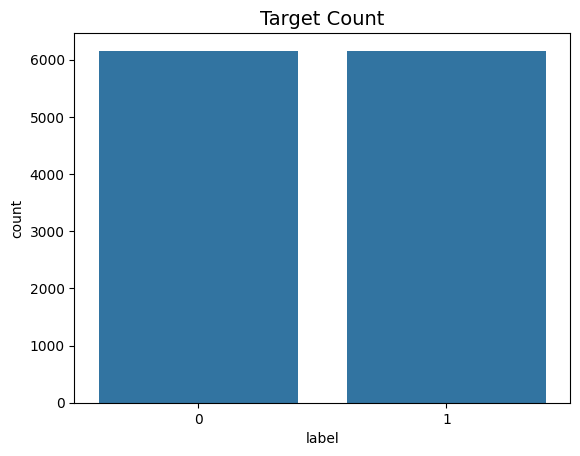

In [ ]:
label = df_news["label"].value_counts()
sns.barplot(x=label.index, y=label)
plt.title('Target Count', fontsize=14)

In [ ]:
df_news.drop_duplicates(subset=['translated'],keep='first',inplace=True)
df_news.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8660 entries, 1036 to 1301
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   translated  8660 non-null   object
 1   label       8660 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 203.0+ KB


In [ ]:
print('Number of 0 (Not Fake) : ', df_news["label"].value_counts()[0])
print('Number of 1 (Fake) : ', df_news["label"].value_counts()[1])

Number of 0 (Not Fake) :  5179
Number of 1 (Fake) :  3481


In [ ]:
# Dataset Preprocessing
def text_cleaning(translated):
    translated = re.sub(r'[^ऀ-ॿ]', ' ', translated) # removing punctuation
    return translated

df_news['translated'] = df_news['translated'].apply(text_cleaning)

In [ ]:
train_df,eval_df = train_test_split(df_news,test_size = 0.05)

In [ ]:
# from collections import Counter
# df_list = [word for sentence in df_news['translated'] for word in sentence.split()]

# # Create a Counter dictionary from the list of words
# dictionary = Counter(df_list)

# # 1. Verify file existence and path
# print("Checking if font file exists:", os.path.exists(font_path))
# print("Absolute path of font file:", os.path.abspath(font_path))

# # 2. Attempt to open the font file directly (for permission check)
# try:
#     with open(font_path, 'rb') as f:
#         print("Font file opened successfully. Permissions seem okay.")
# except OSError as e:
#     print("Error opening font file:", e)


# # Specify the path to the font file
# font_path = "gargi.ttf"

# # Generate the word cloud
# wordcloud = WordCloud(
#     width=1000,
#     height=700,
#     background_color='white',
#     min_font_size=10,
#     font_path=font_path
# ).generate_from_frequencies(dictionary)

# # Display the word cloud
# plt.figure(figsize=(10, 7))
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis('off')
# plt.show()

In [ ]:
# Splitting the dataset
train_df, test_df = train_test_split(df_news, test_size=0.2, stratify=df_news['label'], random_state=42)
train_texts, train_labels = train_df['translated'].values, train_df['label'].values
test_texts, test_labels = test_df['translated'].values, test_df['label'].values

In [ ]:

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("ai4bharat/indic-bert")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
# Tokenize data
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(list(test_texts), truncation=True, padding=True, max_length=128)


In [ ]:
# Convert to torch tensors
train_inputs = torch.tensor(train_encodings['input_ids'])
train_masks = torch.tensor(train_encodings['attention_mask'])
train_labels = torch.tensor(train_labels.astype(int)) # Convert labels to integers
test_inputs = torch.tensor(test_encodings['input_ids'])
test_masks = torch.tensor(test_encodings['attention_mask'])
test_labels = torch.tensor(test_labels.astype(int)) # Convert labels to integers

In [ ]:
# Create DataLoader
batch_size = 32

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)


In [ ]:
# Load pre-trained model
model = AutoModelForSequenceClassification.from_pretrained("ai4bharat/indic-bert", num_labels=2)
model.to(torch.device("cuda"))

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


AlbertForSequenceClassification(
  (albert): AlbertModel(
    (embeddings): AlbertEmbeddings(
      (word_embeddings): Embedding(200000, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0, inplace=False)
    )
    (encoder): AlbertTransformer(
      (embedding_hidden_mapping_in): Linear(in_features=128, out_features=768, bias=True)
      (albert_layer_groups): ModuleList(
        (0): AlbertLayerGroup(
          (albert_layers): ModuleList(
            (0): AlbertLayer(
              (full_layer_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (attention): AlbertAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768

In [ ]:
# Optimizer and scheduler
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(), lr=1e-5, eps=1e-8)
epochs = 5
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)


In [ ]:

# Training and validation
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(time.strftime("%H:%M:%S", time.gmtime(elapsed_rounded)))

In [ ]:
# Function to save checkpoint
def save_checkpoint(model, tokenizer, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    model_to_save = model.module if hasattr(model, 'module') else model
    model_to_save.save_pretrained(output_dir)
    tokenizer.save_pretrained(output_dir)

In [ ]:

# Ensure the checkpoint directory exists
checkpoint_dir = '/content/drive/MyDrive/Indic_Auth_Data_checkpoints/'
os.makedirs(checkpoint_dir, exist_ok=True)

In [ ]:
import os
# Training loop with W&B logging and checkpointing
best_loss = None
early_stopping_counter = 0
checkpoint_dir = '/content/drive/MyDrive/Indic_Auth_Data_checkpoints'
loss_values = []

for epoch_i in range(0, epochs):
    print(f'======== Epoch {epoch_i + 1} / {epochs} ========')
    print('Training...')
    t0 = time.time()
    total_loss = 0
    model.train()

    for step, batch in enumerate(train_dataloader):
        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print(f'  Batch {step}  of  {len(train_dataloader)}.    Elapsed: {elapsed}.')

        b_input_ids = batch[0].to(torch.device("cuda"))
        b_input_mask = batch[1].to(torch.device("cuda"))
        b_labels = batch[2].to(torch.device("cuda"))
        model.zero_grad()
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        # Log the training loss to W&B
        wandb.log({"batch_loss": loss.item()})

    avg_train_loss = total_loss / len(train_dataloader)
    loss_values.append(avg_train_loss)
    print("")
    print(f"  Average training loss: {avg_train_loss:.2f}")
    print(f"  Training epoch took: {format_time(time.time() - t0)}")

    print("")
    print("Running Validation...")
    t0 = time.time()
    model.eval()
    eval_loss = 0
    eval_accuracy = 0
    nb_eval_steps = 0

    for batch in test_dataloader:
        batch = tuple(t.to(torch.device("cuda")) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

        logits = outputs.logits
        loss = outputs.loss
        eval_loss += loss.item()
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

    eval_loss = eval_loss / nb_eval_steps
    avg_val_accuracy = eval_accuracy / nb_eval_steps
    print(f"  Validation Loss: {eval_loss:.2f}")
    print(f"  Accuracy: {avg_val_accuracy:.2f}")
    print(f"  Validation took: {format_time(time.time() - t0)}")

    # Log validation metrics to W&B
    wandb.log({"avg_train_loss": avg_train_loss, "avg_val_accuracy": avg_val_accuracy, "avg_val_loss": eval_loss})


    # Save the checkpoint
    checkpoint_path = os.path.join(checkpoint_dir, f"checkpoint_epoch_{epoch_i+1}")
    save_checkpoint(model, tokenizer, checkpoint_path)

      # Save validation loss to a file
    val_loss_file = os.path.join(checkpoint_path, 'validation_loss.txt')
    with open(val_loss_file, 'w') as file:
        file.write(str(eval_loss)) # Save the validation loss to the file

    # Check for the best checkpoint
    if best_loss is None or eval_loss < best_loss:
        best_loss = eval_loss
        best_checkpoint_path = checkpoint_path
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1

    if early_stopping_counter >= 2:
        print("Early stopping triggered. Stopping training.")
        break

print("")
print("Training complete!")
wandb.finish()


======== Epoch 1 / 5 ========
Training...
  Batch 40  of  217.    Elapsed: 00:00:28.
  Batch 80  of  217.    Elapsed: 00:00:55.
  Batch 120  of  217.    Elapsed: 00:01:20.
  Batch 160  of  217.    Elapsed: 00:01:46.
  Batch 200  of  217.    Elapsed: 00:02:12.

  Average training loss: 0.37
  Training epoch took: 00:02:23

Running Validation...
  Validation Loss: 0.25
  Accuracy: 0.92
  Validation took: 00:00:12
======== Epoch 2 / 5 ========
Training...
  Batch 40  of  217.    Elapsed: 00:00:26.
  Batch 80  of  217.    Elapsed: 00:00:52.
  Batch 120  of  217.    Elapsed: 00:01:18.
  Batch 160  of  217.    Elapsed: 00:01:44.
  Batch 200  of  217.    Elapsed: 00:02:10.

  Average training loss: 0.14
  Training epoch took: 00:02:20

Running Validation...
  Validation Loss: 0.15
  Accuracy: 0.96
  Validation took: 00:00:12
======== Epoch 3 / 5 ========
Training...
  Batch 40  of  217.    Elapsed: 00:00:26.
  Batch 80  of  217.    Elapsed: 00:00:52.
  Batch 120  of  217.    Elapsed: 00:01:18

avg_train_loss,█▃▂▂▁
avg_val_accuracy,▁▆███
avg_val_loss,█▂▁▁▂
batch_loss,█▇▅▅▅█▃▃▂▃▁▃▃▂▂▂▁▁▁▁▃▆▁▃▁▁▃▁▁▄▄▃▅▁▂▁▁▁▃▁
avg_train_loss,0.03836
avg_val_accuracy,0.96818
avg_val_loss,0.13717
batch_loss,0.03403


In [ ]:
best_checkpoint_dir = '/content/drive/MyDrive/Indic_Auth_Data_best_checkpoint/'

In [ ]:
# Function to load a checkpoint
def load_checkpoint(model_class, tokenizer_class, load_directory):
    model = model_class.from_pretrained(load_directory)
    tokenizer = tokenizer_class.from_pretrained(load_directory)
    return model, tokenizer

In [ ]:
import shutil
# Find the checkpoint with the lowest validation loss
best_checkpoint = None
best_loss = float('inf')
for item in os.listdir(checkpoint_dir):
    checkpoint_path = os.path.join(checkpoint_dir, item)
    if os.path.isdir(checkpoint_path):
        # Load validation loss from a file
        val_loss_file = os.path.join(checkpoint_path, 'validation_loss.txt')
        if os.path.exists(val_loss_file):
            with open(val_loss_file, 'r') as file:
                val_loss = float(file.read().strip())
            if val_loss < best_loss:
                best_loss = val_loss
                best_checkpoint = checkpoint_path
        else:
            print(f"Warning: Validation loss file not found for checkpoint: {checkpoint_path}") # Added warning

# Load the best checkpoint
if best_checkpoint:
    print(f"Loading best checkpoint from {best_checkpoint} with validation loss {best_loss:.4f}")
    model, tokenizer = load_checkpoint(AutoModelForSequenceClassification, AutoTokenizer, best_checkpoint)
    model.to(device)

    # Save the best checkpoint to a specific directory in Google Drive
    shutil.copytree(best_checkpoint, best_checkpoint_dir)
    print(f"Best checkpoint saved to {best_checkpoint_dir}")
else:
    # Modified error message to be more informative
    raise ValueError(f"No valid checkpoints found in {checkpoint_dir}. Check if checkpoints were saved and contain 'validation_loss.txt'.")

Loading best checkpoint from /content/drive/MyDrive/Indic_Auth_Data_checkpoints/checkpoint_epoch_3 with validation loss 0.1242
Best checkpoint saved to /content/drive/MyDrive/Indic_Auth_Data_best_checkpoint/


In [ ]:
# Evaluate the model on the test set
def evaluate_model(dataloader, model):
    model.eval()
    predictions, true_labels = [], []

    for batch in dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

        logits = outputs.logits
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        predictions.append(logits)
        true_labels.append(label_ids)

    pred_labels = np.concatenate([np.argmax(p, axis=1) for p in predictions], axis=0)
    true_labels = np.concatenate(true_labels, axis=0)

    accuracy = accuracy_score(true_labels, pred_labels)
    recall = recall_score(true_labels, pred_labels)
    precision = precision_score(true_labels, pred_labels)
    f1 = f1_score(true_labels, pred_labels)

    return accuracy, recall, precision, f1

# Evaluate on test data
accuracy, recall, precision, f1 = evaluate_model(test_dataloader, model)

print(f'Accuracy: {accuracy:.2f}')
print(f'Recall: {recall:.2f}')
print(f'Precision: {precision:.2f}')
print(f'F1 Score: {f1:.2f}')

Accuracy: 0.97
Recall: 0.96
Precision: 0.95
F1 Score: 0.96


In [ ]:
# Function to make predictions and return true and predicted labels
def predict_test_data(dataloader, model):
    model.eval()
    predictions, true_labels = [], []

    for batch in dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

        logits = outputs.logits
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        predictions.append(logits)
        true_labels.append(label_ids)

    # Handle the case where dataloader is empty
    if predictions:
        pred_labels = np.concatenate([np.argmax(p, axis=1) for p in predictions], axis=0)
        true_labels = np.concatenate(true_labels, axis=0)
    else:
        pred_labels = np.array([]) # Return empty numpy arrays if no predictions
        true_labels = np.array([])

    return true_labels, pred_labels

# Add a check to see if the dataloader is empty before calling predict_test_data
if test_dataloader:
    # Get true and predicted labels for the test data
    true_labels, pred_labels = predict_test_data(test_dataloader, model)
else:
    print("Warning: test_dataloader is empty. No predictions generated.")
    true_labels, pred_labels = np.array([]), np.array([]) # Assign empty arrays

In [ ]:
# Create a DataFrame with the true labels and predictions
results_df_test = pd.DataFrame({
    'Sentence': test_texts,
    'True Label': true_labels,
    'Predicted Label': pred_labels
})


In [ ]:
# # Save the DataFrame to a CSV file with a filename
# results_df_test.to_csv('/content/drive/MyDrive/data/Hindi_Fake_news_data/Auth_test_predictions.csv', index=False)
# print("Test predictions saved to /content/drive/MyDrive/data/Hindi_Fake_news_data/Auth_test_predictions.csv")

In [ ]:
# import pandas as pd
# # Read the CSV file into a pandas DataFrame
# test_predictions = pd.read_csv('/content/drive/MyDrive/data/test_predictions.csv')

# # Display the DataFrame
# test_predictions

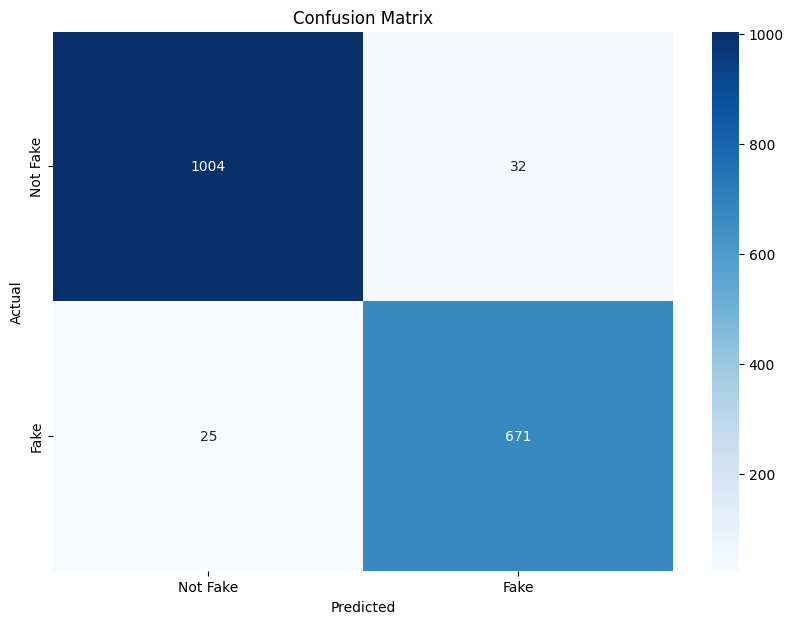

In [ ]:
# Calculate the confusion matrix for the test predictions
cm_test = confusion_matrix(true_labels, pred_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fake', 'Fake'], yticklabels=['Not Fake', 'Fake'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

#Logistic Regression


In [ ]:
# Vectorization
vectorization = TfidfVectorizer()
xv_train = vectorization.fit_transform(train_texts)
xv_test = vectorization.transform(test_texts)

In [ ]:
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression()
LR.fit(xv_train,train_labels)

LogisticRegression()

In [ ]:
pred_lr=LR.predict(xv_test)
accuracy = LR.score(xv_test, test_labels) * 100
print(f"Accuracy: {accuracy:.2f}%")
print(classification_report(test_labels, pred_lr))

Accuracy: 93.76%
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      1036
           1       0.97      0.87      0.92       696

    accuracy                           0.94      1732
   macro avg       0.94      0.93      0.93      1732
weighted avg       0.94      0.94      0.94      1732



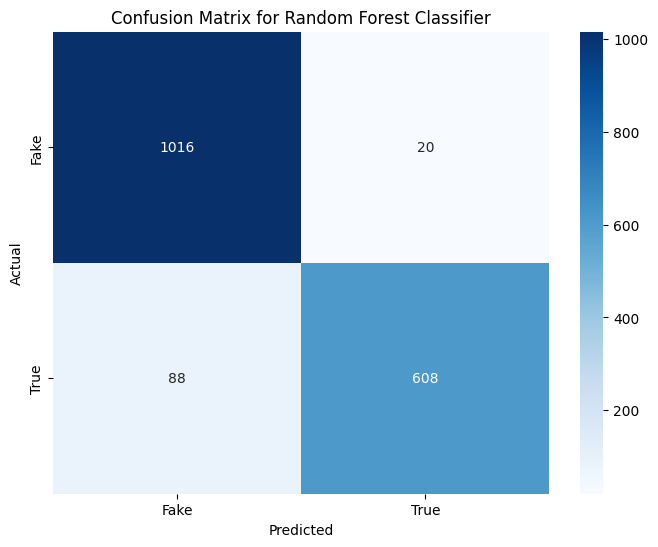

In [ ]:
confusion_mat = confusion_matrix(test_labels, pred_lr)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'True'], yticklabels=['Fake', 'True'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Random Forest Classifier')
plt.show()

In [ ]:
# BERT Model Predictions
def get_bert_predictions(dataloader, model):
    model.eval()
    predictions = []

    for batch in dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

        logits = outputs.logits
        predictions.append(logits.detach().cpu().numpy())

    return np.concatenate(predictions, axis=0)

bert_train_preds = get_bert_predictions(train_dataloader, model)
bert_test_preds = get_bert_predictions(test_dataloader, model)


In [ ]:
# Ensemble Predictions using weighted average
ensemble_train_preds = (0.5 * bert_train_preds + 0.5 * LR.predict_proba(xv_train))
ensemble_test_preds = (0.5 * bert_test_preds + 0.5 * LR.predict_proba(xv_test))

ensemble_train_preds_labels = np.argmax(ensemble_train_preds, axis=1)
ensemble_test_preds_labels = np.argmax(ensemble_test_preds, axis=1)

In [ ]:
# Evaluate the ensemble model
accuracy = accuracy_score(test_labels, ensemble_test_preds_labels)
recall = recall_score(test_labels, ensemble_test_preds_labels)
precision = precision_score(test_labels, ensemble_test_preds_labels)
f1 = f1_score(test_labels, ensemble_test_preds_labels)

print(f'Ensemble Model Accuracy: {accuracy:.2f}')
print(f'Ensemble Model Recall: {recall:.2f}')
print(f'Ensemble Model Precision: {precision:.2f}')
print(f'Ensemble Model F1 Score: {f1:.2f}')
print(classification_report(test_labels, ensemble_test_preds_labels))


Ensemble Model Accuracy: 0.97
Ensemble Model Recall: 0.96
Ensemble Model Precision: 0.96
Ensemble Model F1 Score: 0.96
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1036
           1       0.96      0.96      0.96       696

    accuracy                           0.97      1732
   macro avg       0.97      0.97      0.97      1732
weighted avg       0.97      0.97      0.97      1732



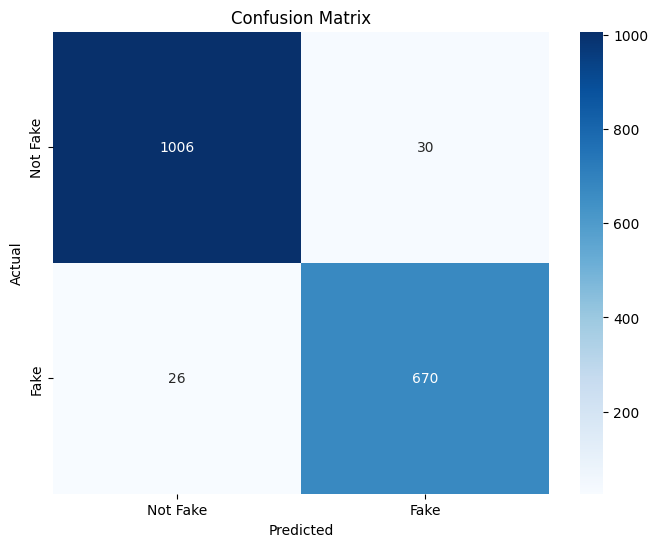

In [ ]:
# Confusion Matrix
confusion_mat = confusion_matrix(test_labels, ensemble_test_preds_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fake', 'Fake'], yticklabels=['Not Fake', 'Fake'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier

RFC = RandomForestClassifier(random_state=0)
RFC.fit(xv_train, train_labels)

RandomForestClassifier(random_state=0)

In [ ]:
pred_rfc = RFC.predict(xv_test)
accuracy = RFC.score(xv_test, test_labels) * 100
print(f"Accuracy: {accuracy:.2f}%")
print(classification_report(test_labels, pred_rfc))

Accuracy: 94.05%
              precision    recall  f1-score   support

           0       0.93      0.98      0.95      1036
           1       0.97      0.88      0.92       696

    accuracy                           0.94      1732
   macro avg       0.95      0.93      0.94      1732
weighted avg       0.94      0.94      0.94      1732



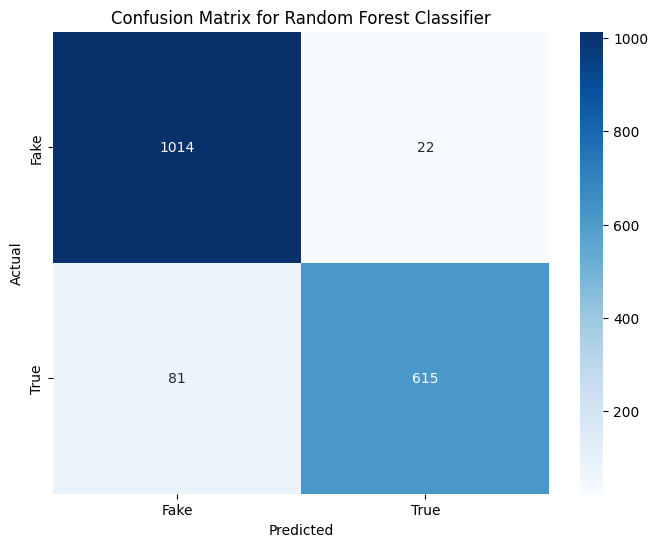

In [ ]:

confusion_mat = confusion_matrix(test_labels, pred_rfc)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'True'], yticklabels=['Fake', 'True'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Random Forest Classifier')
plt.show()

In [ ]:
# Ensemble Predictions using weighted average
ensemble_train_preds = (0.5 * bert_train_preds + 0.5 * RFC.predict_proba(xv_train))
ensemble_test_preds = (0.5 * bert_test_preds + 0.5 * RFC.predict_proba(xv_test))

ensemble_train_preds_labels = np.argmax(ensemble_train_preds, axis=1)
ensemble_test_preds_labels = np.argmax(ensemble_test_preds, axis=1)

In [ ]:
# Evaluate the ensemble model
accuracy = accuracy_score(test_labels, ensemble_test_preds_labels)
recall = recall_score(test_labels, ensemble_test_preds_labels)
precision = precision_score(test_labels, ensemble_test_preds_labels)
f1 = f1_score(test_labels, ensemble_test_preds_labels)

print(f'Ensemble Model Accuracy: {accuracy:.2f}')
print(f'Ensemble Model Recall: {recall:.2f}')
print(f'Ensemble Model Precision: {precision:.2f}')
print(f'Ensemble Model F1 Score: {f1:.2f}')
print(classification_report(test_labels, ensemble_test_preds_labels))


Ensemble Model Accuracy: 0.97
Ensemble Model Recall: 0.96
Ensemble Model Precision: 0.95
Ensemble Model F1 Score: 0.96
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      1036
           1       0.95      0.96      0.96       696

    accuracy                           0.97      1732
   macro avg       0.97      0.97      0.97      1732
weighted avg       0.97      0.97      0.97      1732



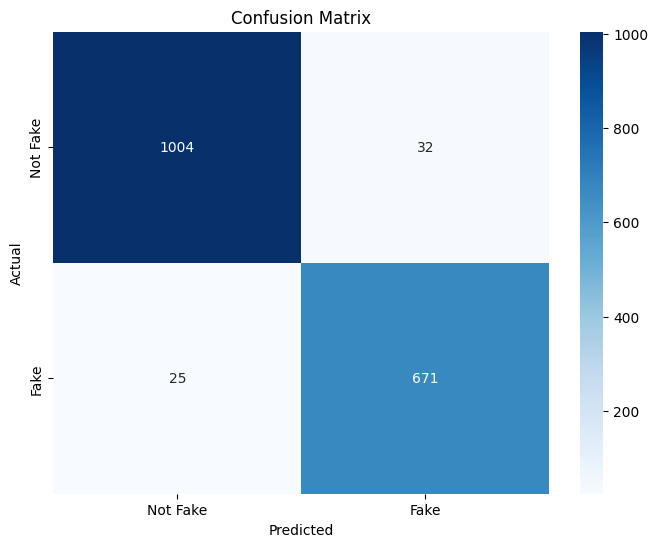

In [ ]:
# Confusion Matrix
confusion_mat = confusion_matrix(test_labels, ensemble_test_preds_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fake', 'Fake'], yticklabels=['Not Fake', 'Fake'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()